In [1]:
import matplotlib.pyplot as plt
import sklearn as sk

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Activation

from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np

C:\Users\Michele\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# IMPORT

In [2]:
df = pd.read_csv('train.csv').dropna(axis=0).reset_index(drop=True)

df = df[['stock_id','seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap','target']]

In [3]:
df.head(10)

,stock_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target
0,0,300,0.00,0,1.000241,26670118.88,1.000241,1.000241,1.000026,19319.31,1.000241,16149.55,1.000143,-10.039806
1,1,300,242332.96,-1,1.000073,3242054.27,0.981974,0.994490,0.999544,43205.40,1.000308,2042.76,1.000273,-1.329780
2,2,300,0.00,0,1.000193,4671376.00,1.000193,1.000193,0.999035,18971.00,1.001036,59688.26,0.999518,14.009476
3,3,300,2914730.16,1,0.999870,41057776.66,1.003870,1.002279,0.999827,25569.50,1.000042,37897.50,0.999914,-4.339814
4,4,300,3396923.02,1,0.998496,38356174.88,1.007894,1.007894,0.998357,14446.00,0.998703,2601.18,0.998650,10.850430
5,5,300,0.00,0,1.001878,19816808.10,1.001878,1.001878,1.001531,77171.78,1.001980,6147.00,1.001947,-6.279945
6,6,300,2290880.11,1,1.000493,6222660.84,1.020254,1.008032,1.000010,110949.94,1.000493,476.41,1.000490,-2.139807
7,7,300,5743260.87,-1,0.997609,59880787.67,0.972086,0.992924,0.997609,6410.30,0.998138,17958.36,0.997748,11.379719
8,8,300,3049995.87,1,0.999183,21575575.33,1.016710,1.005503,0.998155,6495.81,1.000248,299433.78,0.998200,0.729561
9,9,300,0.00,0,1.000484,12825322.65,1.000484,1.000484,1.000323,18529.03,1.000484,7871.46,1.000436,-15.140176


In [4]:
df.shape

(2343638, 14)

# ENRICHMENT

In [5]:
wap_ratio = [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]
for i in range(len(df)-6): #it plugs different days as seconds before, it does not consider any discontinuity
    wap_ratio.append(df.loc[i+6,'wap']/df.loc[i,'wap'])

In [6]:
df['wap_ratio']=wap_ratio
df['index_ratio']=df['wap_ratio']-df['target']
df = df.dropna(axis=0).reset_index(drop=True)

# ROLLING WINDOW MECHANISM

In [7]:
df0 = df[df['stock_id']==0].reset_index(drop=True)
df0 = df0.iloc[:,1:]

In [8]:
df0.head()

,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,wap_ratio,index_ratio
0,310,0.0,0,0.999919,26670118.88,0.999919,0.999919,0.999812,22767.64,0.999919,18664.00,0.999871,-6.039739,0.998895,7.038634
1,320,0.0,0,0.999919,26670118.88,0.999919,0.999919,0.999705,49262.40,0.999919,37607.96,0.999826,-5.440116,0.998875,6.438991
2,330,0.0,0,0.999812,26670118.88,0.999812,0.999812,0.999705,27990.00,0.999812,14276.43,0.999776,-7.439852,0.998821,8.438673
3,340,0.0,0,0.999491,26670118.88,0.999491,0.999491,0.999169,18743.25,0.999383,40012.83,0.999237,-2.700090,0.998426,3.698517
4,350,0.0,0,0.999169,26670118.88,0.999169,0.999169,0.999062,22564.08,0.999169,37486.50,0.999102,-4.469752,0.998175,5.467927


In [9]:
df0.shape

(11937, 15)

In [10]:
train = int(len(df0)*0.9)
val = int(len(df0)*0.05)
test = len(df0)-train-val

train_df = df0.iloc[:train].reset_index(drop=True)
val_df = df0.iloc[train+1:train+val+1].reset_index(drop=True)
test_df = df0.iloc[train+val+2:].reset_index(drop=True)

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

# scaler = StandardScaler()
# scaler = scaler.fit(train_df)

# train_df = pd.DataFrame(scaler.fit_transform(train_df))
# train_df.columns = df0.columns
# val_df = pd.DataFrame(scaler.fit_transform(val_df))
# val_df.columns = df0.columns
# test_df = pd.DataFrame(scaler.fit_transform(test_df))
# test_df.columns = df0.columns

test_df.head()

,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,wap_ratio,index_ratio
0,0.134718,-0.489364,1.437362,0.625335,1.083015,0.412532,0.385019,0.580786,4.007921,0.577376,-0.793128,0.621416,-1.037591,0.263794,1.037731
1,0.273412,-0.502972,1.437362,0.500465,1.086220,0.329397,0.385019,0.497430,0.285929,0.494148,0.083961,0.502603,-1.399792,0.183953,1.399880
2,0.412106,-0.510457,1.437362,0.542248,1.087048,0.329397,0.385019,0.497430,1.168939,0.494148,0.030518,0.517515,-1.376956,0.341112,1.377135
3,0.550800,-0.725975,0.234466,0.542248,1.110883,0.256683,0.318830,0.497430,0.708936,0.494148,-0.210501,0.517515,-1.279702,0.186908,1.279794
4,0.689494,-0.725975,0.234466,0.292508,1.124234,0.225537,0.269236,0.246398,0.049696,0.243980,1.089995,0.230825,0.014472,-0.016468,-0.014482


In [11]:
def create_sequences1(data, seq_length, forward_step):
    X = []
    y = []
    for i in range(len(data) - seq_length - forward_step):
        X.append(data.loc[i:i+seq_length,['imbalance_size',
       'reference_price', 'matched_size',
       'bid_price', 'bid_size', 'ask_price', 'ask_size', 'wap',
       'wap_ratio', 'index_ratio']].values)
        y.append(data.loc[i+seq_length+forward_step,'target'])
    return np.array(X), np.array(y)

seq_length = 30
forward_step = 0
n_input = len(['imbalance_size',
       'reference_price', 'matched_size',
       'bid_price', 'bid_size', 'ask_price', 'ask_size', 'wap',
       'wap_ratio', 'index_ratio'])

X_train, y_train = create_sequences1(train_df, seq_length, forward_step)
X_val, y_val = create_sequences1(val_df, seq_length, forward_step)
X_test, y_test = create_sequences1(test_df, seq_length, forward_step)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_input))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_input))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_input))

# MODEL

In [12]:
def prelu(x, alpha=tf.Variable(initial_value=0.1, trainable=True)):
    pos = tf.nn.relu(x)
    neg = alpha * (x - abs(x)) * 0.5
    return pos + neg

In [13]:
def range_fitter(x, ranger=tf.Variable(initial_value=tf.ones((50,), dtype=tf.float32), trainable=True)):
    x = tf.cast(x, ranger.dtype)
    return x*ranger

In [14]:
from tensorflow.compat.v1 import keras

optimizer = keras.optimizers.legacy.Adam(learning_rate=0.001)

model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(31, 10)))
model.add(LSTM(50, activation=prelu, return_sequences=True))
model.add(LSTM(50, activation=range_fitter))
model.add(Dense(1))
model.add(Activation('linear'))
model.compile(loss='mse' , optimizer=optimizer , metrics=['mae'])

In [15]:
history = model.fit(X_train , y_train , epochs=40 , steps_per_epoch=50 , verbose=1 ,validation_data=(X_val, y_val) ,shuffle=False)

Epoch 1/40


50/50 [==============================] - 6s 69ms/step - loss: 0.9801 - mae: 0.7251 - val_loss: 0.7414 - val_mae: 0.6705
Epoch 2/40
50/50 [==============================] - 3s 52ms/step - loss: 0.7771 - mae: 0.6306 - val_loss: 3.4198 - val_mae: 0.8903
Epoch 3/40
50/50 [==============================] - 3s 51ms/step - loss: 0.5621 - mae: 0.4845 - val_loss: 0.3449 - val_mae: 0.4508
Epoch 4/40
50/50 [==============================] - 3s 51ms/step - loss: 0.2014 - mae: 0.3021 - val_loss: 0.5103 - val_mae: 0.3550
Epoch 5/40
50/50 [==============================] - 3s 51ms/step - loss: 0.0692 - mae: 0.1810 - val_loss: 0.1043 - val_mae: 0.1903
Epoch 6/40
50/50 [==============================] - 3s 50ms/step - loss: 0.0361 - mae: 0.1309 - val_loss: 0.0652 - val_mae: 0.1434
Epoch 7/40
50/50 [==============================] - 3s 52ms/step - loss: 0.0203 - mae: 0.0954 - val_loss: 0.0513 - val_mae: 0.1290
Epoch 8/40
50/50 [==============================] - 3s 51ms/step - loss: 0.0143 -

In [16]:
pred_train = list(model.predict(X_train))
pred_val = list(model.predict(X_val))
pred_test = list(model.predict(X_test))

18/18 [==============================] - 0s 19ms/step


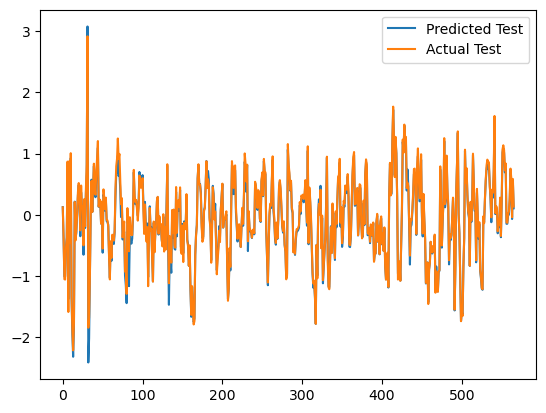

In [17]:
plt.plot(range(test-32),pred_test,label='Predicted Test')
plt.plot(range(test-32),test_df.loc[30:,'target'],label='Actual Test')
plt.legend()